# Filtracja bilateralna

## Konwolucja obrazu z filtrem o zadanych współczynnikach

Splot (konwolucję) obrazu wejściowego $I$ z filtrem $\psi$ dla ustalonego punktu obrazu $\mathbf{x}$ można przedstawić następująco:

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||)I(\mathbf{p})
\end{equation}

gdzie:
- $\hat{I}$ jest obrazem wynikowym (przefiltrowanym),
- $W_N = \sum_y \psi(y)$ jest parametrem normalizującym współczynniki filtra $\psi$,
- $||\cdot||$ jest odległością między punktami obrazu $\mathbf{x}$ i $\mathbf{p}$ według ustalonej metryki (np. norma $L_2$). Uwaga, proszę pamiętać, że zarówno $\mathbf{x}$, jak i $\mathbf{p}$ to współrzędne przestrzenne,
- $\eta(\mathbf{x})$ jest otoczeniem punktu $\mathbf{x}$.

Funkcja $\psi$ decyduje o charakterze filtracji. Dla filtru Gaussowskiego:

\begin{equation}
\psi(y) = G_{\delta_s}(y)
\end{equation}

gdzie: $G_{\delta_s}(y)$ jest funkcją Gaussa z parametrem skali $\delta_s$.

Opisaną powyżej filtrację realizowaliśmy w ramach ćwiczenia "Przetwarzanie wstępne. Filtracja kontekstowa."

## Filtracja bilateralna

Wadą klasycznego splotu jest brak adaptacji współczynników filtra do lokalnego otoczenia $\eta(\mathbf{x})$ filtrowanego punktu $\mathbf{x}$.
Oznacza to wykorzystanie tych samych współczynników filtra $\psi$ niezależnie od tego czy otoczenie jest względnie jednorodne lub zawiera krawędzie obiektów (w tym przypadku dochodzi do "rozmywania" krawędzi).
Filtracja bilateralna uwzględnia lokalne otoczenie filtrowanego punktu, w ten sposób, że parametry filtra zmieniają się w zależności od "wyglądu" otoczenia.


Współczynniki filtra obliczane są na podstawie odległości filtrowanego punktu $\mathbf{x}$ od każdego punktu otoczenia $\mathbf{p}$ w dziedzinie przestrzennej obrazu (tak jak przy typowym filtrze np. Gaussa) oraz odległości punktów w przeciwdziedzinie obrazu (np. na podstawie różnicy w jasności pikseli dla obrazu w odcieniach szarości):

\begin{equation}
\hat{I}(\mathbf{x}) = \frac{1}{W_N}\sum_{\mathbf{p} \in \eta(\mathbf{x})} \psi(||\mathbf{p}-\mathbf{x}||) \gamma(|I(\mathbf{p}) - I(\mathbf{x})|) I(\mathbf{p})
\end{equation}
gdzie:
- $W_N$ jest współczynnikiem normalizującym filtr,
- $\gamma$ jest funkcją odległości w przeciwdziedzinie obrazu, np. $\gamma(y)=\exp(-\frac{y^2}{2\delta_r^2})$
- parametr $\delta_r$ jest utożsamiany z poziomem szumu w obrazie i należy go dobrać w sposób empiryczny.

Proszę chwilę zastanowić się nad powyższym równaniem, w szczególności nad funkcją $\gamma$. Proszę wyznaczyć, jaka będzie wartość funkcji dla pikseli podobnych (różnica 0, 1, 2), a skrajnie różnych (255, 200).

##  Realizacja ćwiczenia

### Wczytanie danych

1. Wczytaj dane z pliku *MR_data.mat*. W tym celu wykorzystaj funkcję `loadmat` z pakietu scipy:
        from scipy.io import loadmat
        mat = loadmat('MR_data.mat')

2. Wczytany plik zawiera 5 obrazów: *I_noisefree*, *I_noisy1*, *I_noisy2*, *I_noisy3* oraz *I_noisy4*. Odczytać je można w następujący sposób:
        Input = mat['I_noisy1']

3.Wyświetl wybrany obraz z pliku *MR_data.mat*. Zagadka - co to za obrazowanie medyczne?

In [1]:
import cv2
import os
import requests
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal
from scipy.io import loadmat
import math

url = 'https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/'

fileNames = ["MR_data.mat"]
for fileName in fileNames:
  if not os.path.exists(fileName):
      r = requests.get(url + fileName, allow_redirects=True)
      open(fileName, 'wb').write(r.content)


def display(*images, size=5):
    n = len(images)
    fig, ax = plt.subplots(1, n, squeeze=False)
    fig.set_size_inches(size*n, size)
    for i, image in enumerate(images):
        ax[0][i].imshow(image)
        ax[0][i].axis('off')

    plt.gray()
    plt.show()

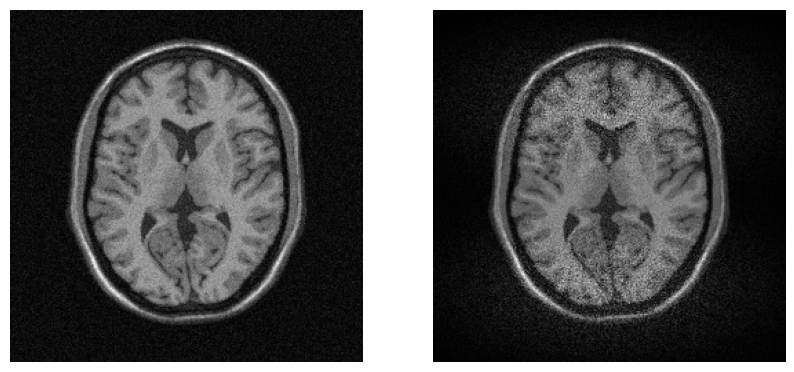

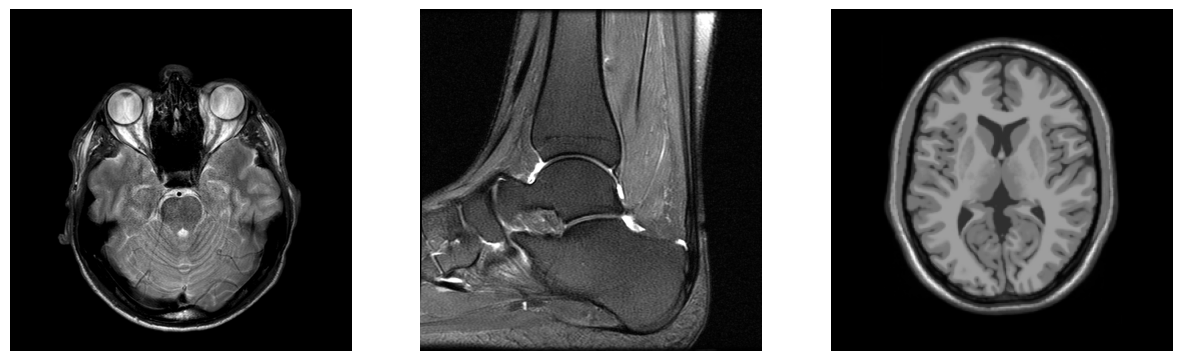

In [3]:
mat = loadmat("MR_data.mat")
display(mat['I_noisy1'], mat['I_noisy2'])
display(mat['I_noisy3'], mat['I_noisy4'], mat['I_noisefree'])

### "Klasyczna" konwolucja

1. Zdefiniuj parametry filtra Gaussowskiego: rozmiar okna i wariancję $\delta_S$.
2. Oblicz współczynniki filtra na podstawie zdefiniowanych parametrów (najprościej w ramach podwójnej pętli for).
2. Sprawdź ich poprawność i zwizualizuj filtr (tak jak w ćwiczeniu pt. "Przetwarzanie wstępne. Filtracja kontekstowa.").
3. Wykonaj kopię obrazu wejściowego: `IConv = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentem tej funkcji są aktualnie przetwarzane okno i współczynniki filtra.
7. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
8. Wyświetl wynik filtracji.
9. Porównaj wynik z obrazem oryginalnym.

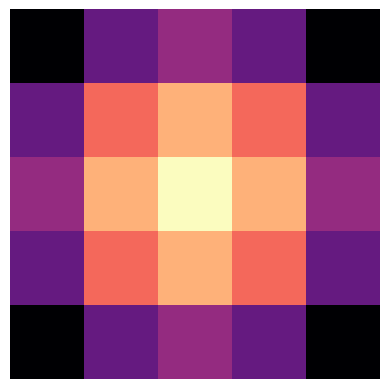

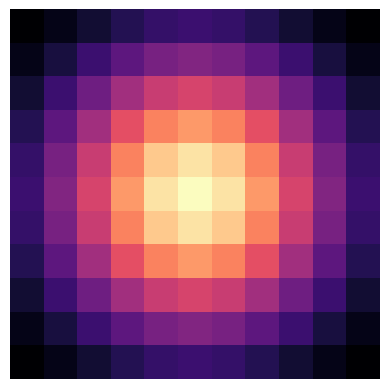

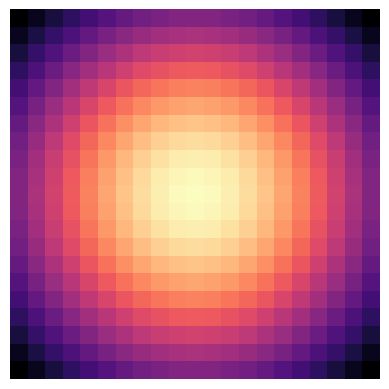

In [4]:
from itertools import product


def create_gauss_kernel(w_size: int=5, sigma: float=2.5, show: bool=False):
    if w_size % 2 == 0:
        raise ValueError("Gaussian kernel should have odd length dimensions")
    gauss = lambda x: np.exp(-x**2 / (2*sigma**2))
    gauss_filter = np.zeros((w_size, w_size), dtype=np.float32)
    mid = w_size // 2

    for i, j in product(range(w_size), range(w_size)):
        dist = np.sqrt((i - mid)**2 + (j - mid)**2)
        gauss_filter[i, j] = gauss(dist)

    if show:
        plt.imshow(gauss_filter, cmap='magma')
        plt.axis('off')
        plt.show()

    gauss_filter /= np.sum(gauss_filter)
    return gauss_filter

create_gauss_kernel(w_size=5, sigma=2.5, show=True)
create_gauss_kernel(w_size=11, sigma=3, show=True)
create_gauss_kernel(w_size=21, sigma=10, show=True);

In [9]:
def convolution(image, w_size=5, sigma=2.5):
    if w_size % 2 == 0:
        raise ValueError("Gaussian kernel should have odd length dimensions")
    image_copy = image.astype(dtype=np.float32)
    half = w_size // 2
    kernel = create_gauss_kernel(w_size, sigma)
    m, n = image.shape
    for i in range(half, m - half):
        for j in range(half, n - half):
            image_copy[i, j] = np.sum(kernel*image[i-half:i+half + 1, j-half:j+half + 1].astype(np.float32))

    display(image_copy.astype(np.uint8), image)

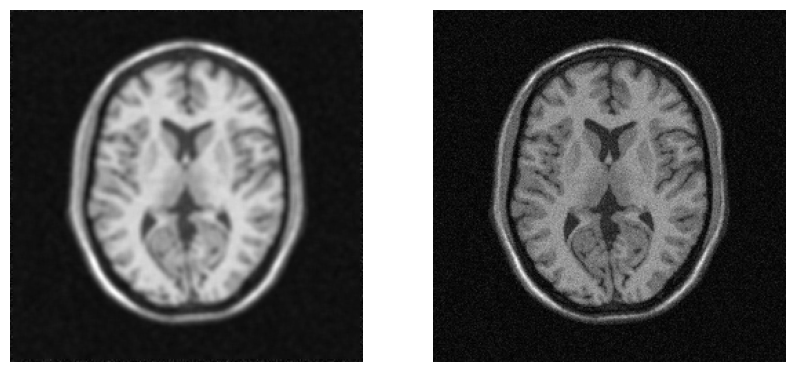

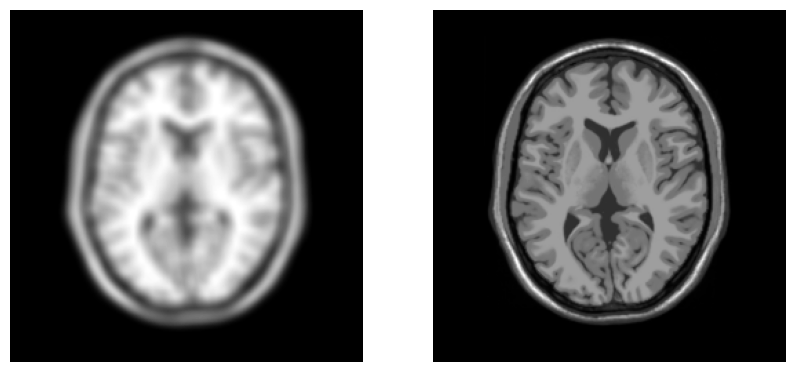

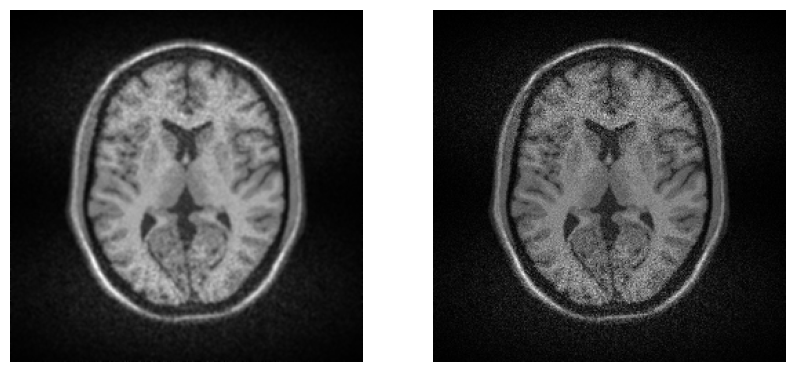

In [11]:
convolution(mat['I_noisy1'])
convolution(mat['I_noisefree'], w_size=11, sigma=5)
convolution(mat['I_noisy2'], w_size=3, sigma=1)

### Filtracja bilateralna

1. Zdefiniuj dodatkowy parametr: wariancję $\delta_R$.
3. Wykonaj kopię obrazu wejściowego: `IBilateral = Input.copy()`
4. Wykonaj podwójną pętlę po obrazie. Pomiń ramkę, dla której nie jest zdefiniowany kontekst o wybranej wielkości.
5. W każdej iteracji stwórz dwuwymiarową tablicę zawierającą aktualny kontekst.
6. Napisz funkcję, która będzie obliczała nową wartość piksela.
Argumentami funkcji są aktualnie przetwarzane okno, współczynniki filtra gausowskiego (takie same jak wcześniej) i wariancja $\delta_R$.
7. Oblicz odległość w przeciwdziedzinie (dla wartości pikseli).
8. Oblicz funkcję Gaussa dla obliczonych odległości z zadanym parametrem.
9. Wykonaj normalizację obliczonych współczynników.
10. Obliczoną wartość przypisz do odpowiedniego piksela kopii obrazu wejściowego.
11. Wyświetl wynik filtracji.
12. Porównaj wynik z obrazem oryginalnym.

In [12]:
def calculate_pixel_value(window, w_size, kernel, image_diff):
    mid = w_size // 2
    for i, j in product(range(w_size), range(w_size)):
        kernel[i, j] *= image_diff(np.abs(window[i, j] - window[mid, mid]))

    kernel /= np.sum(kernel)
    return np.sum(kernel*window)


def bilateral(image, w_size=5, sigma=2.5, sigma_R=5):
    if w_size % 2 == 0:
        raise ValueError("Kernel should have odd length dimensions")

    image_copy = image.astype(np.float32)

    gaussian_kernel = create_gauss_kernel(w_size, sigma)
    image_diff = lambda x: np.exp(-x**2 / (2*sigma_R**2))
    mid = w_size // 2
    m, n = image.shape
    for i in range(mid, m - mid):
        for j in range(mid, n - mid):
            window = image[i-mid:i+mid + 1, j-mid:j+mid + 1].astype(np.float32)
            image_copy[i, j] = calculate_pixel_value(window, w_size, gaussian_kernel.copy(), image_diff)

    display(image_copy.astype(np.uint8), image)

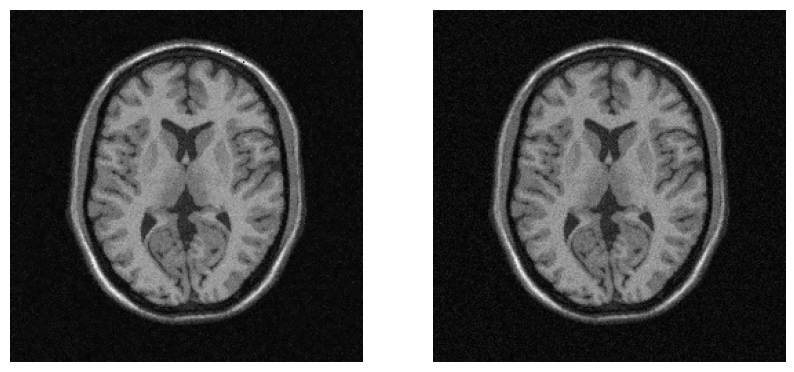

In [13]:
bilateral(mat['I_noisy1'], sigma_R=5)

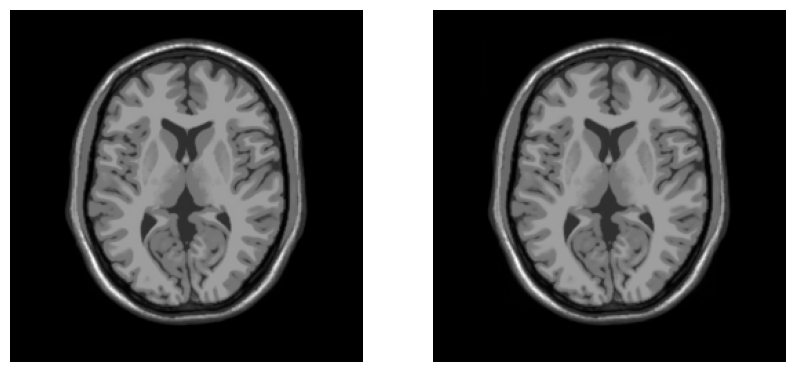

In [14]:
bilateral(mat['I_noisefree'], sigma_R=2)

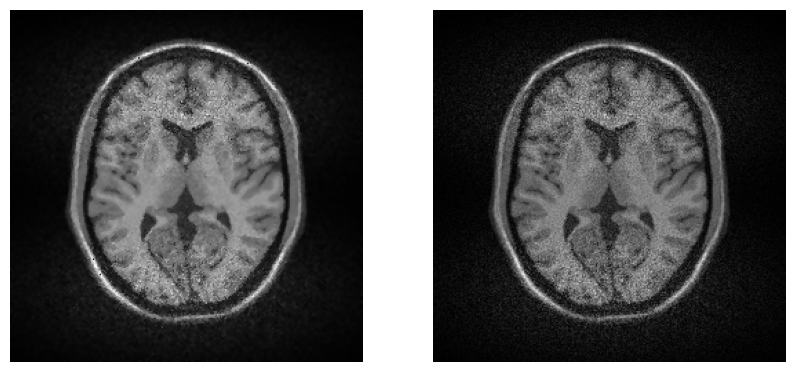

In [15]:
bilateral(mat['I_noisy2'], w_size=3, sigma=3, sigma_R=20)

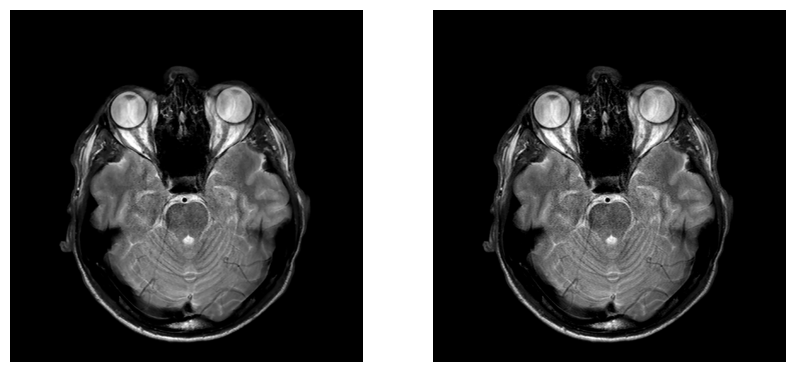

In [16]:
bilateral(mat['I_noisy3'], w_size=3, sigma=1.5, sigma_R=10)